# Presentation

In this notebook we explore 1D optimal transport by computing the barycenter between spectra. 

We'll first explore 1D OT on diracs followed by 1D OT on pure sine waves. In the end we explore this method on real signals.

We'll compute barycenters using 3 functions:

* Quantile method   
* Entropic barycenter 
* Regularized sinkhorn

In [7]:
import librosa
import IPython
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import ot

## OT between diracs

In this part we compute 1D Optimal transport between diracs


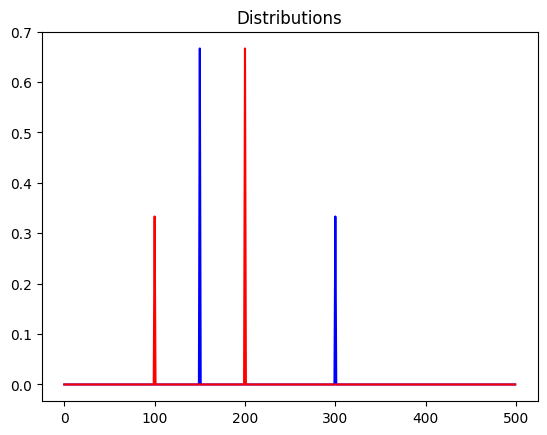

In [209]:
# Optimal transport
n = 500

def dirac_distribution(frequencies, values, n=1000):
    if not len(frequencies) == len(values):
        raise ValueError("Arrays should be same size")
    a = np.zeros(n)
    for i in range(len(frequencies)):
        f = int(frequencies[i])
        v = values[i]
        a[f] = v
    return a / np.sum(a)

a1 = dirac_distribution([n* 0.3, n* 0.6], [1, 0.5], n=n)
a2 = dirac_distribution([n* 0.2, n* 0.4], [0.5, 1], n=n)

frequencies = np.arange(n)

plt.plot(frequencies, a1, color="blue")
plt.plot(frequencies, a2, color="red")
plt.title('Distributions')

plt.show()



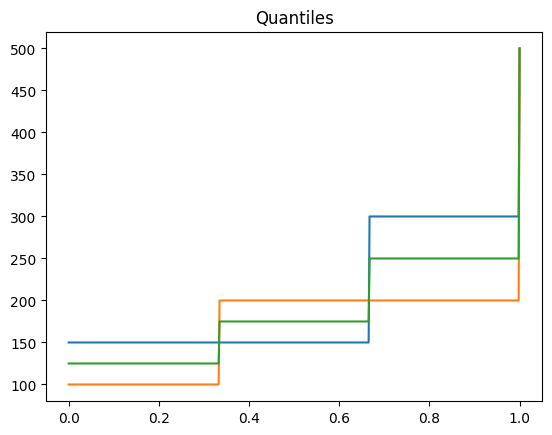

In [210]:
def quantile(a):
    n = len(a)
    X = np.cumsum(a)
    U = np.linspace(0, 1, n)

    return np.searchsorted(X, U, side='right')

def quantile_bary(a1, a2, alpha=0.5):
    q1 = quantile(a1)
    q2 = quantile(a2)
    
    return (1 - alpha) * q1 + alpha * q2

U = np.linspace(0, 1, n)

plt.plot(U,quantile(a1))
plt.plot(U,quantile(a2))
plt.plot(U,quantile_bary(a1, a2))
plt.title('Quantiles')
plt.show()


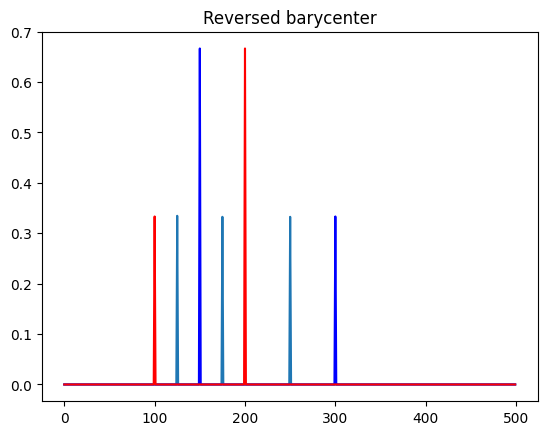

In [211]:
z = quantile_bary(a1, a2)

def reverse_bary(z):
    n = len(z)
    frequencies, values = np.unique(z, return_counts=True)
    return dirac_distribution(frequencies[:-1], values[:-1], n=n)

plt.plot(frequencies, reverse_bary(z))
plt.plot(frequencies, a1, color="blue")
plt.plot(frequencies, a2, color="red")
plt.title("Reversed barycenter")
plt.show()

# Between gaussians

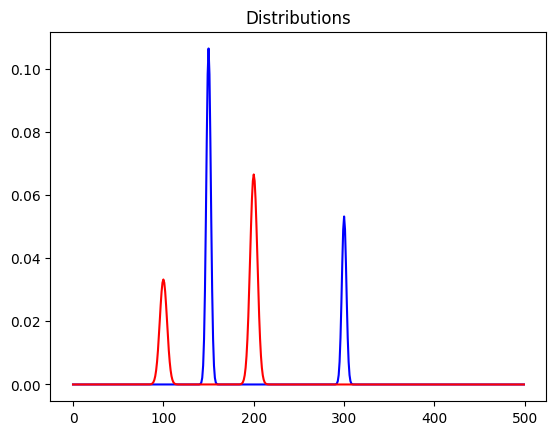

In [212]:
# We compute two 1000-bins gaussian distributions with different mean and std

n = 500
x = np.arange(n, dtype=np.float64)

f1 = n * 0.3
f2 = n * 0.2
s1 = n * 0.005
s2 = n * 0.008

# Gaussian distributions
a1 = 1.0 * ot.datasets.make_1D_gauss(n, m=f1, s=s1) + 0.5 * ot.datasets.make_1D_gauss(n, m=f1*2, s=s1)
a1 = a1 / np.sum(a1)
a2 = 0.5 * ot.datasets.make_1D_gauss(n, m=f2, s=s2) + 1.0 * ot.datasets.make_1D_gauss(n, m=f2*2, s=s2)
a2 = a2 / np.sum(a2)

fig, ax = plt.subplots()
ax.plot(x, a1, color="blue")
ax.plot(x, a2, color="red")
ax.set_title('Distributions')

plt.show()

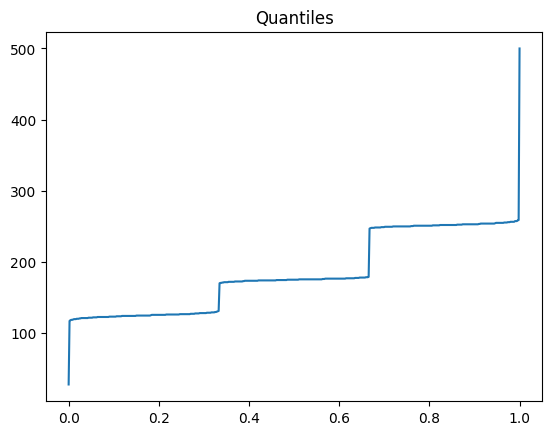

In [213]:
U = np.linspace(0, 1, n)

# plt.plot(U,quantile(a1))
# plt.plot(U,quantile(a2))
plt.plot(U,quantile_bary(a1, a2))
plt.title('Quantiles')
plt.show()


(27.0, 1)
(116.5, 1)
(117.5, 1)
(118.0, 2)
(118.5, 1)
(119.0, 3)
(119.5, 3)
(120.0, 2)
(120.5, 8)
(121.0, 5)


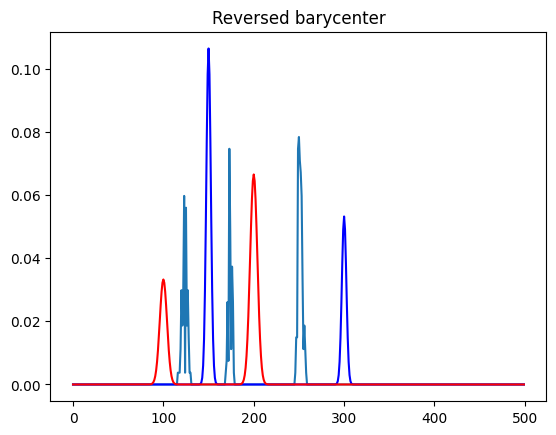

In [214]:
z = quantile_bary(a1, a2)

def reverse_bary(z):
    n = len(z)
    frequencies, values = np.unique(z, return_counts=True)
    for i in range(10):
        print(list(zip(frequencies, values))[i])
    return dirac_distribution(frequencies[1:-1], values[1:-1], n=n)

plt.plot(frequencies, reverse_bary(z))
plt.plot(frequencies, a1, color="blue")
plt.plot(frequencies, a2, color="red")
plt.title("Reversed barycenter")
plt.show()

In [204]:
z

array([ 27. , 116.5, 117.5, 118. , 118. , 118.5, 119. , 119. , 119. ,
       119.5, 119.5, 119.5, 120. , 120. , 120.5, 120.5, 120.5, 120.5,
       120.5, 120.5, 120.5, 120.5, 121. , 121. , 121. , 121. , 121. ,
       121.5, 121.5, 121.5, 121.5, 121.5, 122. , 122. , 122. , 122. ,
       122. , 122. , 122. , 122. , 122. , 122. , 122. , 122. , 122. ,
       122.5, 122.5, 122.5, 122.5, 122.5, 122.5, 122.5, 122.5, 123. ,
       123. , 123. , 123. , 123. , 123. , 123.5, 123.5, 123.5, 123.5,
       123.5, 123.5, 123.5, 123.5, 123.5, 123.5, 123.5, 123.5, 123.5,
       123.5, 123.5, 123.5, 124. , 124. , 124. , 124. , 124. , 124. ,
       124. , 124. , 124. , 124. , 124. , 124. , 124. , 124. , 124. ,
       124. , 124.5, 125. , 125. , 125. , 125. , 125. , 125. , 125. ,
       125. , 125. , 125. , 125. , 125. , 125. , 125. , 125. , 125. ,
       125.5, 125.5, 125.5, 125.5, 125.5, 125.5, 125.5, 125.5, 125.5,
       125.5, 125.5, 125.5, 125.5, 125.5, 125.5, 126. , 126. , 126. ,
       126. , 126. ,